<a href="https://colab.research.google.com/github/Igor-C-Assuncao/MVP_Series_temporais_NN/blob/main/Igor_Assuncao_MVP_ML_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Template — MVP: *Machine Learning & Analytics*
**Autor:** Igor Cassimiro Assunção

**Data:** 27/09/2025

**Matrícula:** 2025000

**Dataset:** Ex: [Iris Dataset](https://archive.ics.uci.edu/dataset/53/iris)

> **Importante:**
A estrutura base deste notebook pode servir como um guia inicial para desenvolver suas análises, já que contempla grande parte das sugestões do checklist apresentado no enunciado do MVP. Entretanto, é importante destacar que esta estrutura é apenas um ponto de partida: poderão ser necessárias etapas e análises adicionais além das aqui exemplificadas.

> O essencial é garantir profundidade nas discussões e análises, construindo um storytelling consistente que explore os principais conceitos e técnicas vistos nas aulas da Sprint de Machine Learning & Analytics.

> Lembre-se: não existe uma receita pronta. A ordem e as seções detalhadas abaixo são apenas sugestões. O problema escolhido e a história que você deseja contar devem guiar, em grande parte, a forma final do seu trabalho.

---



## ✅ Checklist do MVP (o que precisa conter)
- [ ] **Problema definido** e contexto de negócio
- [ ] **Carga e preparação** dos dados (sem vazamento de dados)
- [ ] **Divisão** em treino/validação/teste (ou validação cruzada apropriada)
- [ ] **Tratamento**: limpeza, transformação e **engenharia de atributos**
- [ ] **Modelagem**: comparar abordagens/modelos (com **baseline**)
- [ ] **Otimização de hiperparâmetros**
- [ ] **Avaliação** com **métricas adequadas** e discussão de limitações
- [ ] **Boas práticas**: seeds fixas, tempo de treino, recursos computacionais, documentação
- [ ] **Pipelines reprodutíveis** (sempre que possível)



## 1. Escopo, objetivo e definição do problema
**TODO:** Explique brevemente:
- Contexto do problema e objetivo (ex.: previsão de churn, detecção de fraude, previsão de demanda, segmentação de clientes etc.).  
- Tipo de tarefa: **classificação**, **regressão**, **clusterização** ou **séries temporais (forecasting)**.  
- Área de aplicação: visão computacional, NLP, dados tabulares, sensores, etc.  
- Valor para o negócio/usuário.



## 2. Reprodutibilidade e ambiente
Especifique o ambiente. Por exemplo:
- Bibliotecas usadas.
- Seeds fixas para reprodutibilidade.

In [2]:
# === Setup básico e reprodutibilidade ===
import os, random, time, sys, math
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             silhouette_score, recall_score, precision_score)

from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform

SEED = 47
np.random.seed(SEED)
random.seed(SEED)

# Para frameworks que suportam seed adicional (ex.: PyTorch/TensorFlow), documente aqui:
# import torch; torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
# import tensorflow as tf; tf.random.set_seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 47



### 2.1 Dependências (opcional)
Instale pacotes extras se necessário. **Mantenha o projeto enxuto** para facilitar a correção.


In [ ]:
!pip install kagglehub[pandas-datasets]


### 2.2 Funções python (opcional)
Defina, se necessário, funções em Python para reutilizar seu código e torná-lo mais organizado. Essa é uma boa prática de programação que facilita a leitura, manutenção e evolução do seu projeto.

In [ ]:
def evaluate_classification(y_true, y_pred, proba=None):
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    auc = roc_auc_score(y_true, proba[:,1]) if (proba is not None and proba.shape[1]==2) else np.nan
    return {"accuracy": acc, "f1_weighted": f1w, "roc_auc": auc}

def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def evaluate(y_true, y_pred, proba=None):
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    auc = roc_auc_score(y_true, proba[:,1]) if (proba is not None and proba.shape[1]==2) else np.nan
    recall = recall_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted")
    return {"accuracy": acc, "f1_weighted": f1w, "roc_auc": auc, "recall": recall, "precision": precision}

def make_windows(X_array, y_array=None, T=128, stride=16):
    X_array = np.asarray(X_array)
    if X_array.ndim != 2:
        raise ValueError("Esperado X em (T_total, F)")
    T_total, F = X_array.shape
    idxs = list(range(0, T_total - T + 1, stride))
    X_win = np.stack([X_array[i:i+T, :] for i in idxs], axis=0).astype(np.float32)
    if y_array is None:
        return X_win, None
    else:
        y_array = np.asarray(y_array)
        # janela anômala = max do período (ajuste se necessário)
        y_win = np.array([y_array[i:i+T].max() for i in idxs]).astype(np.int64)
        return X_win, y_win

print("make_windows pronto.")


## 3. Dados: carga, entendimento e qualidade
**TODO:** descreva a origem dos dados, dicionário de variáveis e licença/ética quando aplicável.  
Evite **vazamento de dados**. Se usar feature store ou dados sintéticos, explique.


In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "industrial_fault_detection_data_1000.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ziya07/industrial-iot-fault-detection-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())


/tmp/ipython-input-2279158378.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 113k/113k [00:00<00:00, 744kB/s]

First 5 records:              Timestamp  Vibration (mm/s)  Temperature (°C)  Pressure (bar)  \
0  2023-03-10 00:00:00          0.437086         64.810634        7.785117   
1  2023-03-10 00:01:00          0.955643         93.352076        7.740936   
2  2023-03-10 00:02:00          0.758795        119.835667        9.718764   
3  2023-03-10 00:03:00          0.638793        108.577991        7.748639   
4  2023-03-10 00:04:00          0.240417        114.524892        7.815849   

   RMS Vibration  Mean Temp  Fault Label  
0       0.601657  90.561384            1  
1       0.601657  90.561384            1  
2       0.601657  90.561384            0  
3       0.601657  90.561384            1  
4       0.601657  90.561384            0  


In [ ]:

# === Verificações iniciais ===
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())


,Timestamp,Vibration (mm/s),Temperature (°C),Pressure (bar),RMS Vibration,Mean Temp,Fault Label
518,2023-03-10 08:38:00,0.988549,69.478584,9.063166,0.601657,90.561384,0
871,2023-03-10 14:31:00,0.343670,67.080909,9.839370,0.601657,90.561384,0
797,2023-03-10 13:17:00,0.608620,55.766747,8.867030,0.601657,90.561384,0
274,2023-03-10 04:34:00,0.560208,88.440556,9.851593,0.601657,90.561384,1
325,2023-03-10 05:25:00,0.764107,76.951663,9.865182,0.601657,90.561384,1



Formato: (1000, 7)

Tipos:
Timestamp            object
Vibration (mm/s)    float64
Temperature (°C)    float64
Pressure (bar)      float64
RMS Vibration       float64
Mean Temp           float64
Fault Label           int64
dtype: object

Valores ausentes por coluna:
Timestamp           0
Vibration (mm/s)    0
Temperature (°C)    0
Pressure (bar)      0
RMS Vibration       0
Mean Temp           0
Fault Label         0
dtype: int64



### 3.1 Análise exploratória resumida (EDA)
**TODO:** inclua gráficos e tabelas essenciais para entender o problema e levantar hipóteses.  
Evite EDA muito extensa — foque no que afeta as decisões de modelagem.


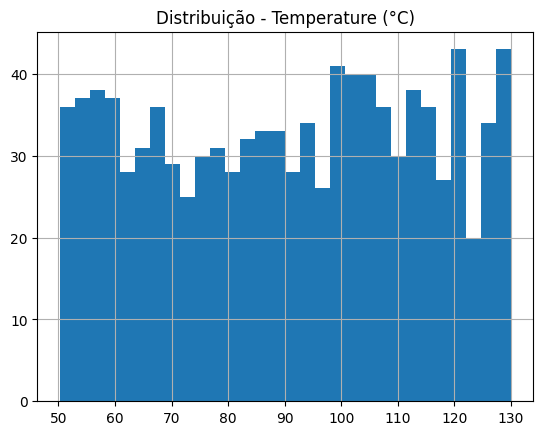

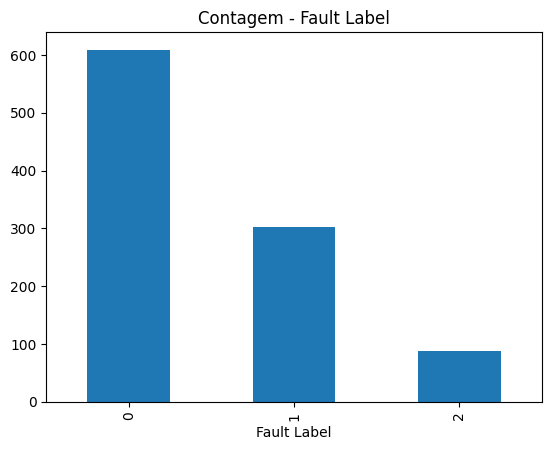

In [5]:
# Histograma numérico (exemplo)
_ = df["Temperature (°C)"].hist(bins=30)
plt.title("Distribuição - Temperature (°C)")
plt.show()

# Contagem categórica (exemplo)
_ = df["Fault Label"].value_counts().plot(kind="bar")
plt.title("Contagem - Fault Label")
plt.show()



## 4. Definição do target, variáveis e divisão dos dados
**TODO:** escolha o **target** (ou defina a tarefa de clusterização/forecast).  
- Em **séries temporais**, **não embaralhe** e use divisões temporais (ex.: `TimeSeriesSplit`).
- Em **classificação desequilibrada**, considere **estratégias para desbalanceamento** (ex.: `class_weight`, undersampling/oversampling).

> **Atenção:** Todas as **transformações** aprendidas devem ser **ajustadas no treino** e **aplicadas no validação/teste**. Recomendamos usar **pipelines**.


In [6]:

PROBLEM_TYPE = "serie_temporal"
target = "Fault Label"  # Exemplo
features = [c for c in df.columns if c not in [target]]


print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", len(features))

# Divisão dos dados


# Ordenar por tempo e criar cortes temporais (exemplo simples hold-out temporal)
df_sorted = df.sort_values("Timestamp")
cutoff = int(len(df_sorted)*0.8)
train, test = df_sorted.iloc[:cutoff], df_sorted.iloc[cutoff:]
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test   = test.drop(columns=[target]),  test[target]
print("Treino:", X_train.shape, "| Teste:", X_test.shape)

PROBLEM_TYPE: serie_temporal
Target: Fault Label
N features: 6
Treino: (800, 6) | Teste: (200, 6)



## 5. Tratamento de dados e **Pipeline** de pré-processamento
Crie um **Pipeline** com as etapas necessárias (limpeza, imputação, encoding, escala, seleção de atributos, etc.)  
Isso garante **reprodutibilidade** e evita **vazamento**.


In [ ]:
num_cols = [c for c in X_train.columns if str(X_train[c].dtype).startswith(("float","int"))]
cat_cols = [c for c in X_train.columns if c not in num_cols and c != "timestamp"]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

print("num_cols:", num_cols[:5], "...")
print("cat_cols:", cat_cols[:5], "...")

num_cols: ['feature_num_1', 'feature_num_2', 'target_reg'] ...
cat_cols: ['feature_cat_1'] ...



## 6. Baseline e modelos candidatos
Se possivek, comece com uma **baseline simples** (ex.: DummyClassifier/Regressor) e evolua para modelos mais fortes. O baseline pode ser seu primeiro modelo!  

**Compare** ao menos **duas abordagens**.

> Para **deep learning** (visão computacional/NLP/séries), crie uma seção específica (p. ex., `TensorFlow`/`PyTorch`) e documente arquitetura, parâmetros e tempo de treino.


In [ ]:
# === Baselines ===
if PROBLEM_TYPE == "classificacao":
    baseline = Pipeline(steps=[("pre", preprocess),
                               ("model", DummyClassifier(strategy="most_frequent", random_state=SEED))])
    candidates = {
        "LogisticRegression": Pipeline([("pre", preprocess), ("model", LogisticRegression(max_iter=200, random_state=SEED))]),
        "RandomForest": Pipeline([("pre", preprocess), ("model", RandomForestClassifier(random_state=SEED))])
    }
elif PROBLEM_TYPE == "regressao":
    baseline = Pipeline(steps=[("pre", preprocess),
                               ("model", DummyRegressor(strategy="median"))])
    candidates = {
        "Ridge": Pipeline([("pre", preprocess), ("model", Ridge(random_state=SEED))]),
        "RandomForestReg": Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))])
    }
elif PROBLEM_TYPE == "clusterizacao":
    # baseline não se aplica diretamente; use um método simples (ex.: KMeans com k fixo) como referência.
    baseline = Pipeline(steps=[("pre", preprocess),
                               ("model", KMeans(n_clusters=3, random_state=SEED))])
    candidates = {
        "KMeans_k3": Pipeline([("pre", preprocess), ("model", KMeans(n_clusters=3, random_state=SEED))]),
        "KMeans_k5": Pipeline([("pre", preprocess), ("model", KMeans(n_clusters=5, random_state=SEED))])
    }
elif PROBLEM_TYPE == "serie_temporal":
    # Em séries temporais, a baseline pode ser "naive" (último valor) — aqui, apenas um placeholder.
    # Para modelos clássicos, pode considerar por exemplo Regressores com janelas (feature engineering temporal).
    baseline = None
    candidates = {}
else:
    raise ValueError("PROBLEM_TYPE inválido.")

baseline


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_num_1',
                                                   'feature_num_2',
                                                   'target_reg']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['feature_cat_1'])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

In [ ]:
# Modelo Proposto



# === Transformers sklearn ===
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV



class WindowizerTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, window_size=128, stride=16):
        self.window_size = window_size; self.stride = stride
    def fit(self, X, y=None): return self
    def transform(self, X):
        Xw, _ = make_windows(X, None, T=self.window_size, stride=self.stride)
        return Xw  # (N, T, F)

# === Estimator Torch (compatível com sklearn) ===
class AEEstimatorTorch(BaseEstimator, TransformerMixin):
    def __init__(self, model_key="tcn_ae", n_features=None,
                 filters=(32,64), kernel_size=3, dilations=(1,2,4,8), causal=True,
                 rnn_type="gru", rnn_units=64, activation="gelu", dropout=0.1,
                 lr=1e-3, loss="huber", epochs=20, batch_size=128, patience=5,
                 device="cuda"):
        self.model_key=model_key; self.n_features=n_features
        self.filters=filters; self.kernel_size=kernel_size; self.dilations=dilations; self.causal=causal
        self.rnn_type=rnn_type; self.rnn_units=rnn_units
        self.activation=activation; self.dropout=dropout
        self.lr=lr; self.loss=loss; self.epochs=epochs; self.batch_size=batch_size; self.patience=patience
        self.device=device

    def _build(self, F):
        params=dict(filters=self.filters, kernel_size=self.kernel_size, dropout=self.dropout, activation=self.activation)
        if self.model_key=="cnn_ae":
            return AEModelA(n_features=F, **params)
        elif self.model_key=="tcn_ae":
            return AEModelB(n_features=F, filters=self.filters, kernel_size=self.kernel_size,
                            dilations=self.dilations, causal=self.causal,
                            dropout=self.dropout, activation=self.activation)
        else:
            return AEModelC(n_features=F, filters=self.filters, kernel_size=self.kernel_size,
                            rnn_type=self.rnn_type, rnn_units=self.rnn_units,
                            dropout=self.dropout, activation=self.activation)

    def fit(self, X, y=None):
        # X here should be (N, T, F) if WindowizerTransformer is before in the Pipeline
        import torch
        F = X.shape[-1] if self.n_features is None else self.n_features
        self.model_ = self._build(F).to(self.device)
        lr = self.lr
        optimizer = torch.optim.Adam(self.model_.parameters(), lr=lr)
        loss_fn = HuberLoss() if self.loss=="huber" else mae_loss
        # loader único (autoencoder reconstrói X)
        tr_ds = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32))
        tr_ld = torch.utils.data.DataLoader(tr_ds, batch_size=self.batch_size, shuffle=True)
        best_state, hist = train_one_fold(self.model_, tr_ld, tr_ld, loss_fn, optimizer,
                                          epochs=self.epochs, early_stopping=self.patience, device=self.device)
        if best_state is not None:
            self.model_.load_state_dict(best_state)
        # threshold with base on training error (optional)
        self.train_errs_ = reconstruct_errors(self.model_, tr_ld, loss_kind=self.loss, device=self.device)
        self.threshold_ = calibrate_threshold(self.train_errs_, q=THRESHOLD_Q)
        return self

    # For sklearn, transform can return the reconstruction
    def transform(self, X):
        import torch, numpy as np
        ds = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32))
        ld = torch.utils.data.DataLoader(ds, batch_size=self.batch_size, shuffle=False)
        recons = []
        self.model_.eval()
        with torch.no_grad():
            for (xb,) in ld:
                xb = xb.to(self.device)
                yb = self.model_(xb).cpu().numpy()
                recons.append(yb)
        return np.concatenate(recons, axis=0)

    # score_samples: error per window (good for detection)
    def score_samples(self, X):
        import torch, numpy as np
        ds = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32))
        ld = torch.utils.data.DataLoader(ds, batch_size=self.batch_size, shuffle=False)
        return reconstruct_errors(self.model_, ld, loss_kind=self.loss, device=self.device)

    # predict: 1=anomalous, 0=normal (using learned threshold)
    def predict(self, X):
        errs = self.score_samples(X)
        return (errs > self.threshold_).astype(int)

# === Example of end-to-end Pipeline (preprocessing + model) ===
scaler_cls = RobustScaler if SCALER=="robust" else StandardScaler
pipe = Pipeline([
    ("impute", ImputerTransformer()),
    ("scale", scaler_cls()),
    ("window", WindowizerTransformer(window_size=WINDOW_SIZE, stride=STRIDE)),
    ("ae", AEEstimatorTorch(model_key="tcn_ae", epochs=20, patience=5, loss="huber", lr=1e-3))
])

# Adjust (in simple holdout, for example)
# pipe.fit(X_full)  # If you just want to train an AE on the set
# errs = pipe.named_steps["ae"].score_samples(pipe.named_steps["window"].transform(pipe.named_steps["scale"].transform(simple_impute(X_full))))
# errs[:5]


### 6.1 Treino e avaliação rápida (baseline vs candidatos)
Use **métricas adequadas** ao tipo de problema. Documente suas observações.


In [ ]:
results = {}

if PROBLEM_TYPE in ["classificacao", "regressao"]:
    # Baseline
    t0 = time.time()
    baseline.fit(X_train, y_train)
    t1 = time.time()
    if PROBLEM_TYPE == "classificacao":
        y_pred = baseline.predict(X_test)
        proba = baseline.predict_proba(X_test) if hasattr(baseline, "predict_proba") else None
        results["baseline"] = evaluate_classification(y_test, y_pred, proba)
    else:
        y_pred = baseline.predict(X_test)
        results["baseline"] = evaluate_regression(y_test, y_pred)
    results["baseline"]["train_time_s"] = round(t1 - t0, 3)

    # Candidatos
    for name, pipe in candidates.items():
        t0 = time.time()
        pipe.fit(X_train, y_train)
        t1 = time.time()
        if PROBLEM_TYPE == "classificacao":
            y_pred = pipe.predict(X_test)
            proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None
            results[name] = evaluate_classification(y_test, y_pred, proba)
        else:
            y_pred = pipe.predict(X_test)
            results[name] = evaluate_regression(y_test, y_pred)
        results[name]["train_time_s"] = round(t1 - t0, 3)

elif PROBLEM_TYPE == "clusterizacao":
    # Baseline e candidatos (ex.: silhouette)
    # Observação: em um projeto real, evite refit em dados de teste fora de validação apropriada.
    results["baseline"] = evaluate_clustering(X_test, baseline)
    for name, pipe in candidates.items():
        results[name] = evaluate_clustering(X_test, pipe)

elif PROBLEM_TYPE == "serie_temporal":
    # TODO: implemente métricas específicas (ex.: MAE/MAPE/RMSE out-of-time)
    results["baseline_naive"] = {"MAE": None, "MAPE": None, "RMSE": None, "obs": "Implementar baseline temporal."}

pd.DataFrame(results).T


,accuracy,f1_weighted,roc_auc,train_time_s
baseline,0.60,0.450000,0.500000,0.093
LogisticRegression,0.57,0.465415,0.550000,0.095
RandomForest,0.57,0.549299,0.543333,0.728



## 7. Validação e Otimização de Hiperparâmetros
Use **validação cruzada** apropriada ao problema (Ex: **`StratifiedKFold`** para classificação; **`KFold`** para regressão).  
Faça **tuning** com `GridSearchCV`/`RandomizedSearchCV`.


In [ ]:
if PROBLEM_TYPE == "classificacao":
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    model = Pipeline([("pre", preprocess), ("model", RandomForestClassifier(random_state=SEED))])
    param_dist = {
        "model__n_estimators": randint(100, 400),
        "model__max_depth": randint(3, 20),
        "model__min_samples_split": randint(2, 10)
    }
    scorer = "f1_weighted"

elif PROBLEM_TYPE == "regressao":
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model = Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))])
    param_dist = {
        "model__n_estimators": randint(100, 400),
        "model__max_depth": randint(3, 20),
        "model__min_samples_split": randint(2, 10)
    }
    scorer = "neg_root_mean_squared_error"

elif PROBLEM_TYPE == "clusterizacao":
    # Clusterização: tuning diferente (ex.: número de clusters). Métricas internas (silhouette) ou externas (se houver rótulos).
    cv = None
    model = Pipeline([("pre", preprocess), ("model", KMeans(random_state=SEED))])
    param_dist = {"model__n_clusters": randint(2, 10)}
    scorer = None

elif PROBLEM_TYPE == "serie_temporal":
    cv = TimeSeriesSplit(n_splits=5)
    # Ex.: usar um regressor com janelas/defasagens previamente criadas
    model = Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))])
    param_dist = {
        "model__n_estimators": randint(100, 300),
        "model__max_depth": randint(3, 15)
    }
    scorer = "neg_mean_absolute_error"

# Executar busca aleatória (exemplo geral — ajuste para seu caso)
if PROBLEM_TYPE != "clusterizacao":
    search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=cv, scoring=scorer, random_state=SEED, n_jobs=-1, verbose=1)
    search.fit(X_train, y_train)
    print("Melhor score (CV):", search.best_score_)
    print("Melhores parâmetros:", search.best_params_)
else:
    print("Para clusterização, avalie k em um range e compare silhouette/indíces de validade. Ex.: varra k de 2 a 10.")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor score (CV): 0.5402276617001536
Melhores parâmetros: {'model__max_depth': 14, 'model__min_samples_split': 2, 'model__n_estimators': 148}



## 8. Avaliação final, análise de erros e limitações
- **Compare** baseline vs melhor modelo.  
- Faça **análise de erros** (ex.: matriz de confusão, casos pior previstos, resíduos).  
- Discuta **limitações**: dados, métricas, viés, generalização.


              precision    recall  f1-score   support

           0       0.60      0.72      0.65        60
           1       0.39      0.28      0.32        40

    accuracy                           0.54       100
   macro avg       0.50      0.50      0.49       100
weighted avg       0.52      0.54      0.52       100



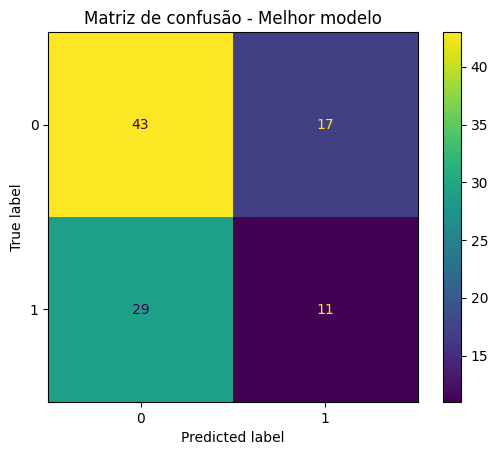

In [ ]:
# Exemplo de re-treino no conjunto de treino+validação (se aplicável) e avaliação no teste

if PROBLEM_TYPE in ["classificacao", "regressao"] and 'search' in globals() and hasattr(search, "best_estimator_"):
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    if PROBLEM_TYPE == "classificacao":
        from sklearn.metrics import classification_report, ConfusionMatrixDisplay
        print(classification_report(y_test, y_pred))
        try:
            ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
            plt.title("Matriz de confusão - Melhor modelo")
            plt.show()
        except Exception as e:
            print("Não foi possível plotar a matriz de confusão:", e)
    else:
        print('Metricas para avaliar a regressão: ', evaluate_regression(y_test, y_pred))
elif PROBLEM_TYPE == "clusterizacao":
    print("Realize análise qualitativa/negócio dos clusters. Visualize centros e perfis.")
elif PROBLEM_TYPE == "serie_temporal":
    print("Avalie métricas fora do tempo; plote série real vs prevista.")


## 9. Engenharia de atributos (detalhe)
**TODO:** Documente as escolhas: seleção/extração, encoding, criação de variáveis temporais (lags, médias móveis), TF-IDF/embeddings (NLP), augmentations (visão), etc.



## 10. (Opcional) Deep Learning / Fine-tuning
Se usar DL, descreva: arquitetura, hiperparâmetros, _early stopping_, tamanho do batch, épocas, e se houve **fine-tuning** de modelos pré-treinados.



## 11. Boas práticas e rastreabilidade
- **Baseline** claro e justificativas para melhorias.  
- **Pipelines** (evitar vazamento).  
- **Decisões de projeto** documentadas (o que tentou e por quê).



## 12. Conclusões e próximos passos
**TODO:** Resuma resultados, trade-offs, e proponha melhorias futuras (mais dados, features, modelos, tuning).



## 13. Salvando artefatos (modelos e pipeline)
Se o treinamento dos modelos demora mais de 3 minutos, recomendamos salvar o **modelo/pipeline** após o treinamento e depois apenas carregar o arquivo (ex: .pkl, .h5) salvo em outra célula, sem precisar treinar novamente.  